### Project Title

### **Data Driven Insights to Launch a Successful Movie Studio**

### Business Understanding 

The company recognizes the increasing demand for data-driven decision-making in the entertainment industry and aims to establish a competitive movie studio. To achieve this, the company seeks to leverage data analytics to gain a comprehensive understanding of the factors influencing box office success. This includes identifying high-performing genres, analyzing audience preferences across demographics and regions, and evaluating seasonal and regional trends. By uncovering actionable insights, the company aims to optimize its content strategy, maximize revenue, and create impactful movies that resonate with audiences globally.

### Problem Statement

The company aims to establish a new movie studio but lacks sufficient knowledge about the movie industry to make informed decisions. The primary challenge is to identify the factors that contribute to a movie's success at the box office. This includes understanding which genres and themes perform best, analyzing audience preferences across demographics and regions, and evaluating seasonal and regional trends that influence box office performance. By leveraging data-driven insights, the company seeks to develop a strategic framework for creating impactful and competitive movie content that maximizes revenue and audience engagement.


### Objectives 

1. Identify Top-Performing Movie Genres Analyze which genres (e.g., Action, Comedy, Drama) consistently generate the highest box office revenue to guide future content strategy.
2. Evaluate seasonal and regional trends 
3. Identify movie ratings and audience preferences for various genres
4. Analyze the relationship between production budget and worldwide revenue

## Data Understanding 

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

We are drawing the findings from the following datasets **box office mojo, the movie database, movie numbers, im.db**. 

In [2]:
# Loading the data from box office mojo
box_office_mojo = pd.read_csv('bom.movie_gross.csv.gz')
box_office_mojo.head() 

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
# Loading data from the movie database
the_movies_db = pd.read_csv("tmdb.movies.csv.gz")
the_movies_db.tail()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.6,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.6,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.6,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.6,2018-06-22,Trailer Made,0.0,1
26516,26516,"[53, 27]",309885,en,The Church,0.6,2018-10-05,The Church,0.0,1


In [4]:
# Loading data from "the numbers website" 
movie_numbers = pd.read_csv("tn.movie_budgets.csv.gz")
movie_numbers.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [5]:
# Loading data from imdb(sqlite3 database file)
# Path to the unzipped .db file
db_path = 'data/unzippedData/im.db'

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Example: List all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)

Tables in the database: [('movie_basics',), ('directors',), ('known_for',), ('movie_akas',), ('movie_ratings',), ('persons',), ('principals',), ('writers',)]


In [6]:
# Selecting the movie_basics table
movie_basics = pd.read_sql("SELECT * FROM movie_basics;", conn)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [7]:
# Selecting the movie_ratings table
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


### Data Preparation

In preparing for the analysis of the data, missing values were either dropped or filled. 

In [8]:
# General information on box_office_mojo
box_office_mojo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [9]:
# Dropping the foreign gross column
box_office_mojo.drop(columns=["foreign_gross"], inplace=True)

# Filling missing values on studio column
box_office_mojo["studio"].fillna("Unknown", inplace=True)

# Filling missing values on domestic gross with zeros
box_office_mojo["domestic_gross"] = box_office_mojo["domestic_gross"].fillna(0)

In [10]:
# General information 
the_movies_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


From the output above, the_movies_db dataset has 10 columns and 26517 rows. It has no missing values. 

In [11]:
movie_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


From the output above, the movie_numbers dataset has 6 columns and 5781 rows. It has no missing values. 

In [12]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


From the output above, movie_ratings dataset has 3 columns and 73855 rows. It has no missing values. 

In [13]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [14]:
# Filling the runtime minutes column with the mean
movie_basics["runtime_minutes"] = movie_basics["runtime_minutes"].fillna(movie_basics["runtime_minutes"].mean())

In [15]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  146144 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [16]:
# Filling the genre column with Unknown
movie_basics["genres"] = movie_basics["genres"].fillna("Unknown")

# Filling the original title column with Unknown
movie_basics["original_title"] = movie_basics["original_title"].fillna("Unknown")

In [17]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146144 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  146144 non-null  float64
 5   genres           146144 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


From the output above, the dataset had no missing values. 

### Objective 1: Identify Top-Performing Movie Genres Analyze which genres (e.g., Action, Comedy, Drama) consistently generate the highest box office revenue to guide future content strategy.

Under this objective, data from IMDb and Box Office Mojo was merged to analyze genres. The primary genre was extracted, and the data was cleaned by converting runtime to numeric and dropping unnecessary columns. Genres were grouped to calculate average domestic gross, total gross, movie counts, and average IMDb ratings. A bar plot visualized the top 10 genres by average domestic gross, highlighting Adventure, Action, and Mystery as top-performing genres. Recommendations include focusing on these genres to maximize revenue.


In [18]:
# Merge movie basics and ratings from IMDB
imdb_movies = pd.read_sql("""
SELECT 
    mb.movie_id,
    mb.primary_title,
    mb.original_title,
    mb.start_year,
    mb.runtime_minutes,
    mb.genres,
    mr.averagerating,
    mr.numvotes
FROM movie_basics mb
JOIN movie_ratings mr ON mb.movie_id = mr.movie_id
""", conn)

imdb_movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [19]:
# Merge IMDB data with Box Office Mojo data
# We'll use the movie title and year to match records
merged_data = pd.merge(
    box_office_mojo,
    imdb_movies,
    left_on=['title', 'year'],
    right_on=['primary_title', 'start_year'],
    how='inner'
)

merged_data.head()

,title,studio,domestic_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,Toy Story 3,BV,415000000.0,2010,tt0435761,Toy Story 3,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",8.3,682218
1,Inception,WB,292600000.0,2010,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066
2,Shrek Forever After,P/DW,238700000.0,2010,tt0892791,Shrek Forever After,Shrek Forever After,2010,93.0,"Adventure,Animation,Comedy",6.3,167532
3,The Twilight Saga: Eclipse,Sum.,300500000.0,2010,tt1325004,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,2010,124.0,"Adventure,Drama,Fantasy",5.0,211733
4,Iron Man 2,Par.,312400000.0,2010,tt1228705,Iron Man 2,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690


In [20]:
# Clean the merged data
# Extract first genre from the genres column (genres are separated by commas)
merged_data['primary_genre'] = merged_data['genres'].str.split(',').str[0]

# Convert runtime_minutes to numeric
merged_data['runtime_minutes'] = pd.to_numeric(merged_data['runtime_minutes'], errors='coerce')

# Drop unnecessary columns
merged_data = merged_data.drop(['title', 'primary_title', 'original_title'], axis=1)

merged_data.head()

,studio,domestic_gross,year,movie_id,start_year,runtime_minutes,genres,averagerating,numvotes,primary_genre
0,BV,415000000.0,2010,tt0435761,2010,103.0,"Adventure,Animation,Comedy",8.3,682218,Adventure
1,WB,292600000.0,2010,tt1375666,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,Action
2,P/DW,238700000.0,2010,tt0892791,2010,93.0,"Adventure,Animation,Comedy",6.3,167532,Adventure
3,Sum.,300500000.0,2010,tt1325004,2010,124.0,"Adventure,Drama,Fantasy",5.0,211733,Adventure
4,Par.,312400000.0,2010,tt1228705,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690,Action


In [21]:
# Format the output to display full numbers instead of scientific notation for readability
pd.options.display.float_format = '{:,.2f}'.format

In [22]:
# Analyze by genre
genre_analysis = merged_data.groupby('primary_genre').agg({
    'domestic_gross': ['mean', 'sum', 'count'],
    'averagerating': 'mean'
}).sort_values(('domestic_gross', 'mean'), ascending=False)

genre_analysis.head(10)

domestic_gross                         averagerating
                        mean               sum count          mean
primary_genre                                                     
Adventure      89,626,184.92 14,877,946,697.00   166          6.45
Action         69,388,471.89 36,290,170,796.00   523          6.32
Mystery        67,056,600.00    335,283,000.00     5          7.20
Animation      53,007,005.88    901,119,100.00    17          6.37
Horror         39,111,995.59  2,659,615,700.00    68          5.48
Comedy         27,255,379.09 10,820,385,499.00   397          6.13
Biography      26,044,530.71  4,323,392,098.00   166          7.03
Crime          20,735,687.50  1,658,855,000.00    80          6.66
Drama          18,532,458.36  6,097,178,799.00   329          6.58
Romance         9,264,714.29     64,853,000.00     7          5.91

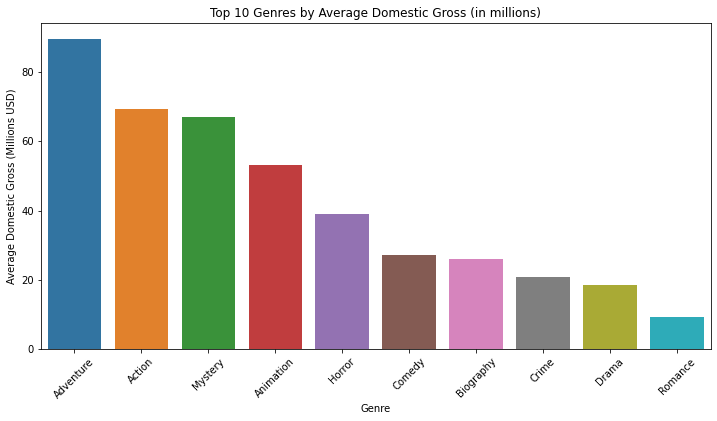

In [23]:
# Plotting the top ten genres 
plt.figure(figsize=(12, 6))
top_genres = genre_analysis.sort_values(('domestic_gross', 'mean'), ascending=False).head(10)
sns.barplot(
    x=top_genres.index,
    y=top_genres[('domestic_gross', 'mean')]/1000000  # Convert to millions
)
plt.title('Top 10 Genres by Average Domestic Gross (in millions)')
plt.xlabel('Genre')
plt.ylabel('Average Domestic Gross (Millions USD)')
plt.xticks(rotation=45)
plt.show()

In [24]:
# Changing the data type of the production budget column to float data type
movie_numbers['production_budget'] = movie_numbers['production_budget'].replace(r'[\$,]', '', regex=True).astype(float)

### 2. Evaluate seasonal and regional trends 

Under Objective 2, the analysis focuses on evaluating seasonal and regional trends in movie performance. The `selected_merged_movies_info` DataFrame is used to categorize movies by season (Winter, Spring, Summer, Fall) based on their release dates. Average domestic and worldwide gross revenues are calculated for each season, revealing that Summer is the highest-grossing season, followed by Spring. A bar plot is created to visualize these trends, providing actionable insights for optimizing movie release schedules to maximize revenue.


In [25]:
# Mapping genre IDs to genre names using a dictionary
genre_dict = {
    28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 80: "Crime",
    99: "Documentary", 18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History",
    27: "Horror", 10402: "Music", 9648: "Mystery", 10749: "Romance", 878: "Science Fiction",
    10770: "TV Movie", 53: "Thriller", 10752: "War", 37: "Western"
}

In [26]:
# Convert genre IDs to genre names
# Map genre IDs to genre names directly
import json
the_movies_db['genre_names'] = the_movies_db['genre_ids'].apply(
    lambda x: [genre_dict.get(genre_id, "Unknown") for genre_id in json.loads(x)]
) # Converting json strings into python objects using json.loads()

# Display the updated DataFrame
the_movies_db[['genre_ids', 'genre_names']].head()

,genre_ids,genre_names
0,"[12, 14, 10751]","[Adventure, Fantasy, Family]"
1,"[14, 12, 16, 10751]","[Fantasy, Adventure, Animation, Family]"
2,"[12, 28, 878]","[Adventure, Action, Science Fiction]"
3,"[16, 35, 10751]","[Animation, Comedy, Family]"
4,"[28, 878, 12]","[Action, Science Fiction, Adventure]"


In [27]:
# Merging the two dataframes
merged_movies_info = movie_numbers.merge(the_movies_db, left_on='movie', right_on='title', how='inner')
merged_movies_info.head()

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,Unnamed: 0,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count,genre_names
0,1,"Dec 18, 2009",Avatar,"425,000,000.00","$760,507,625","$2,776,345,279",6,"[28, 12, 14, 878]",19995,en,Avatar,26.53,2009-12-18,Avatar,7.40,18676,"[Action, Adventure, Fantasy, Science Fiction]"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","$241,063,875","$1,045,663,875",2470,"[12, 28, 14]",1865,en,Pirates of the Caribbean: On Stranger Tides,30.58,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.40,8571,"[Adventure, Action, Fantasy]"
2,4,"May 1, 2015",Avengers: Age of Ultron,"330,600,000.00","$459,005,868","$1,403,013,963",14169,"[28, 12, 878]",99861,en,Avengers: Age of Ultron,44.38,2015-05-01,Avengers: Age of Ultron,7.30,13457,"[Action, Adventure, Science Fiction]"
3,7,"Apr 27, 2018",Avengers: Infinity War,"300,000,000.00","$678,815,482","$2,048,134,200",23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.77,2018-04-27,Avengers: Infinity War,8.30,13948,"[Adventure, Action, Fantasy]"
4,9,"Nov 17, 2017",Justice League,"300,000,000.00","$229,024,295","$655,945,209",20623,"[28, 12, 14, 878]",141052,en,Justice League,34.95,2017-11-17,Justice League,6.20,7510,"[Action, Adventure, Fantasy, Science Fiction]"


In [28]:
# Create a copy of the selected columns from the merged_movies_info dataframe
selected_merged_movies_info = merged_movies_info[['release_date_x', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross', 'popularity', 'vote_average', 'genre_names']].copy()

# Rename the 'release_date_x' column to 'release_date'
selected_merged_movies_info.rename(columns={'release_date_x': 'release_date'}, inplace=True)

# Display the first 5 rows of the updated DataFrame
selected_merged_movies_info.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,popularity,vote_average,genre_names
0,"Dec 18, 2009",Avatar,"425,000,000.00","$760,507,625","$2,776,345,279",26.53,7.40,"[Action, Adventure, Fantasy, Science Fiction]"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","$241,063,875","$1,045,663,875",30.58,6.40,"[Adventure, Action, Fantasy]"
2,"May 1, 2015",Avengers: Age of Ultron,"330,600,000.00","$459,005,868","$1,403,013,963",44.38,7.30,"[Action, Adventure, Science Fiction]"
3,"Apr 27, 2018",Avengers: Infinity War,"300,000,000.00","$678,815,482","$2,048,134,200",80.77,8.30,"[Adventure, Action, Fantasy]"
4,"Nov 17, 2017",Justice League,"300,000,000.00","$229,024,295","$655,945,209",34.95,6.20,"[Action, Adventure, Fantasy, Science Fiction]"


In [29]:
# Convert release date to datetime
selected_merged_movies_info.loc[:, 'release_date'] = pd.to_datetime(selected_merged_movies_info['release_date'])

# Extract month and season
selected_merged_movies_info.loc[:, 'month'] = selected_merged_movies_info['release_date'].dt.month

selected_merged_movies_info.loc[:, 'season'] = selected_merged_movies_info['month'].apply(
    lambda x: 'Winter' if x in [12, 1, 2] 
    else 'Spring' if x in [3, 4, 5] 
    else 'Summer' if x in [6, 7, 8] 
    else 'Fall'
)

selected_merged_movies_info.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,popularity,vote_average,genre_names,month,season
0,2009-12-18,Avatar,"425,000,000.00","$760,507,625","$2,776,345,279",26.53,7.40,"[Action, Adventure, Fantasy, Science Fiction]",12,Winter
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","$241,063,875","$1,045,663,875",30.58,6.40,"[Adventure, Action, Fantasy]",5,Spring
2,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","$459,005,868","$1,403,013,963",44.38,7.30,"[Action, Adventure, Science Fiction]",5,Spring
3,2018-04-27,Avengers: Infinity War,"300,000,000.00","$678,815,482","$2,048,134,200",80.77,8.30,"[Adventure, Action, Fantasy]",4,Spring
4,2017-11-17,Justice League,"300,000,000.00","$229,024,295","$655,945,209",34.95,6.20,"[Action, Adventure, Fantasy, Science Fiction]",11,Fall


In [30]:
# Remove non-numeric characters and convert to float data types of the columns: 
# "production_budget", "domestic_gross" and "worlwide_gross"
def clean_columns(df, columns):
    for column in columns:
        df.loc[:, column] = df[column].replace('[\$,]', '', regex=True).astype(float)
    return df

# Apply the function to clean the specified columns
selected_merged_movies_info = clean_columns(
    selected_merged_movies_info,
    ['production_budget', 'domestic_gross', 'worldwide_gross']
)

# Display the updated DataFrame
selected_merged_movies_info.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,popularity,vote_average,genre_names,month,season
0,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00",26.53,7.40,"[Action, Adventure, Fantasy, Science Fiction]",12,Winter
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",30.58,6.40,"[Adventure, Action, Fantasy]",5,Spring
2,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00",44.38,7.30,"[Action, Adventure, Science Fiction]",5,Spring
3,2018-04-27,Avengers: Infinity War,"300,000,000.00","678,815,482.00","2,048,134,200.00",80.77,8.30,"[Adventure, Action, Fantasy]",4,Spring
4,2017-11-17,Justice League,"300,000,000.00","229,024,295.00","655,945,209.00",34.95,6.20,"[Action, Adventure, Fantasy, Science Fiction]",11,Fall


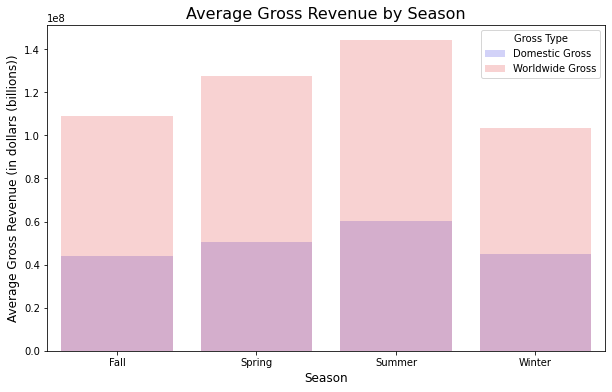

In [31]:
# Group by season and calculate average domestic and worldwide gross
seasonal_trends = selected_merged_movies_info.groupby('season')[['domestic_gross', 'worldwide_gross']].mean().reset_index()

# Plot average gross revenue by season
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='domestic_gross', data=seasonal_trends, label='Domestic Gross', color='blue', alpha=0.2)
sns.barplot(x='season', y='worldwide_gross', data=seasonal_trends, label='Worldwide Gross', color='red', alpha=0.2)
plt.title('Average Gross Revenue by Season', fontsize=16)
plt.ylabel('Average Gross Revenue (in dollars (billions))', fontsize=12)
plt.xlabel('Season', fontsize=12)
plt.legend(title='Gross Type')
plt.show()

In [32]:
# Analyze gross revenue by season
# Group by season and calculate average domestic and worldwide gross
# Grouped worldwide_gross in descending order
seasonal_trends = selected_merged_movies_info.groupby('season')[['domestic_gross', 'worldwide_gross']].mean().sort_values(by="worldwide_gross", ascending=False)

# Print the formatted DataFrame
print(seasonal_trends)

        domestic_gross  worldwide_gross
season                                 
Summer   60,435,024.70   144,181,656.16
Spring   50,374,491.19   127,453,716.95
Fall     44,049,591.98   109,071,823.54
Winter   44,898,693.44   103,218,135.77


### Objective 3. Identify movie ratings and audience preferences for various genres

Under Objective 3, the analysis focuses on understanding the relationship between movie ratings and audience preferences for various genres. The data is grouped by rating bins and genres to calculate average domestic gross and ratings. Visualizations, such as scatter plots and bar plots, are created to explore how IMDB ratings and genre preferences influence domestic gross. The findings highlight that movies with higher ratings (above 8) and certain genres tend to generate higher domestic gross, providing actionable insights for targeting audience preferences.

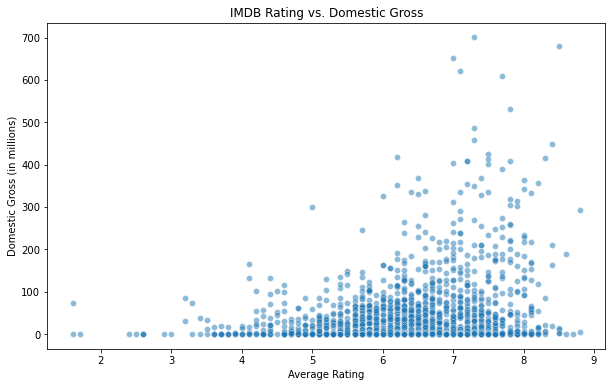

In [33]:
# Analyze ratings vs. domestic gross
# Create a new column in millions
merged_data['domestic_gross_millions'] = merged_data['domestic_gross'] / 1_000_000

# Now plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='averagerating',
    y='domestic_gross_millions',
    data=merged_data,
    alpha=0.5
)
plt.title('IMDB Rating vs. Domestic Gross')
plt.xlabel('Average Rating')
plt.ylabel('Domestic Gross (in millions)')
plt.show()

In [34]:
# Create rating bins
merged_data['rating_bin'] = pd.cut(
    merged_data['averagerating'],
    bins=[0, 5, 6, 7, 8, 10],
    labels=['<5', '5-6', '6-7', '7-8', '8+']
)

rating_analysis = merged_data.groupby('rating_bin')['domestic_gross'].mean().reset_index()

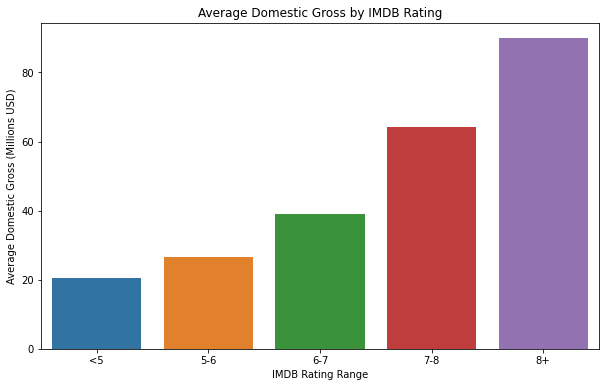

In [35]:
# Visualize rating bins vs. domestic gross
# Calculate domestic gross in millions first
rating_analysis['domestic_gross_millions'] = rating_analysis['domestic_gross'] / 1000000

# Create the visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    x='rating_bin',
    y='domestic_gross_millions',
    data=rating_analysis,
    order=['<5', '5-6', '6-7', '7-8', '8+']
)
plt.title('Average Domestic Gross by IMDB Rating')
plt.xlabel('IMDB Rating Range')
plt.ylabel('Average Domestic Gross (Millions USD)')
plt.show()

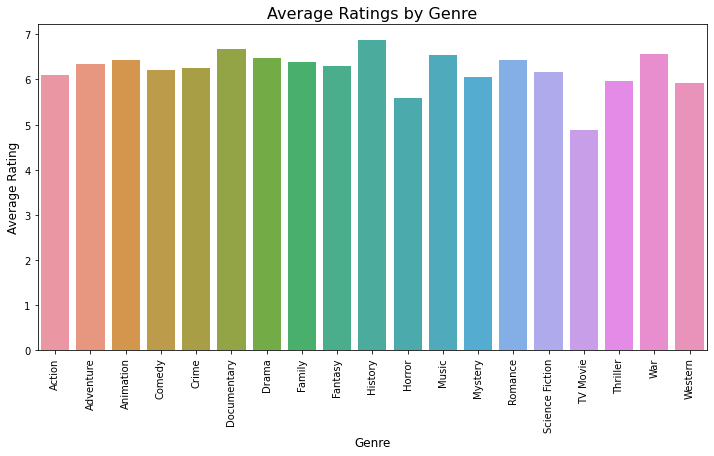

In [36]:
# Explode genre_names to separate each genre into its own row
exploded_movies_info = selected_merged_movies_info.explode('genre_names')

# Group by genre and calculate average ratings and votes
genre_demographics = exploded_movies_info.groupby('genre_names')[['vote_average', 'popularity']].mean().reset_index()

# Plot average ratings by genre
plt.figure(figsize=(12, 6))
sns.barplot(x='genre_names', y='vote_average', data=genre_demographics)
plt.title('Average Ratings by Genre', fontsize=16)
plt.ylabel('Average Rating', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation=90)
plt.show()

### Hypothesis Testing

**Null Hypothesis (H₀)**:
"There is no significant relationship between a movie's average audience rating and its worldwide gross revenue."
This suggests that variations in audience ratings do not have any meaningful effect on a movie's revenue.

**Alternative Hypothesis (H₁)**:
"There is a significant relationship between a movie's average audience rating and its worldwide gross revenue."
This implies that audience ratings and worldwide revenue are statistically associated, indicating that higher ratings might correlate with higher revenue or vice versa.

In [37]:
# Correlation between ratings and worldwide gross
from scipy.stats import pearsonr

# Drop rows with missing values in 'vote_average' or 'worldwide_gross'
ratings_gross_data = selected_merged_movies_info[['vote_average', 'worldwide_gross']].dropna()

# Perform Pearson correlation test
correlation, p_value = pearsonr(ratings_gross_data['vote_average'], ratings_gross_data['worldwide_gross'])
print(f"Correlation: {correlation}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant positive correlation between ratings and worldwide gross.")
else:
    print("There is no significant correlation between ratings and worldwide gross.")

Correlation: 0.19281133600528375, P-value: 2.087525814333377e-21
There is a significant positive correlation between ratings and worldwide gross.


As the p-value is below 0.05, we rejected the null hypothesis. 

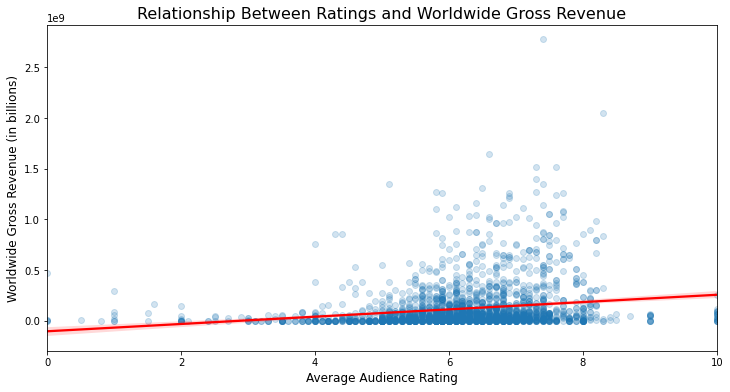

In [38]:
# Scatter plot with regression line for hypothesis testing
plt.figure(figsize=(12, 6))
sns.regplot(
    x='vote_average',
    y='worldwide_gross',
    data=ratings_gross_data,
    scatter_kws={'alpha': 0.2},
    line_kws={'color': 'red'}
)
plt.title('Relationship Between Ratings and Worldwide Gross Revenue', fontsize=16)
plt.xlabel('Average Audience Rating', fontsize=12)
plt.ylabel('Worldwide Gross Revenue (in billions)', fontsize=12)
plt.show()

The scatter plot with a regression line visually represents the relationship between an independent variable ```production_budget``` and a dependent variable ```worldwide_gross```. Each point corresponds to a movie, positioned based on its values for the two variables. The regression line indicates the overall trend in the data. The line has a positive slope suggesting that as production budgets increase, worldwide gross revenue tends to rise as well. This visualization helps determine whether higher budgets are associated with greater earnings in the film industry.

### 4. Analyze the relationship between production budget and worldwide revenue

Under Objective 4, the relationship between production budgets and worldwide gross revenue is analyzed. The `selected_merged_movies_info` DataFrame is used, and a scatter plot with a regression line is created to visualize the correlation between these variables. The analysis aims to determine whether higher production budgets lead to higher worldwide gross revenue. The findings from this analysis provide insights into the financial impact of production budgets on movie performance, helping to guide investment decisions for future productions.

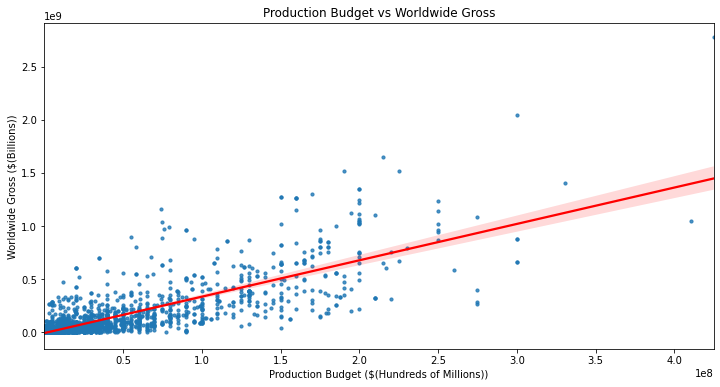

In [39]:
# Scatter plot with a trend line
plt.figure(figsize=(12,6))
sns.regplot(x='production_budget', y='worldwide_gross', data=selected_merged_movies_info, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('Production Budget vs Worldwide Gross')
plt.xlabel('Production Budget ($(Hundreds of Millions))')
plt.ylabel('Worldwide Gross ($(Billions))')
plt.show()

### Analysis of the correlation between production budgets and other features

In [40]:
# Select relevant columns for regression
regression_data = selected_merged_movies_info[['worldwide_gross', 'production_budget', 'popularity', 'vote_average']].copy()
regression_data

,worldwide_gross,production_budget,popularity,vote_average
0,"2,776,345,279.00","425,000,000.00",26.53,7.40
1,"1,045,663,875.00","410,600,000.00",30.58,6.40
2,"1,403,013,963.00","330,600,000.00",44.38,7.30
3,"2,048,134,200.00","300,000,000.00",80.77,8.30
4,"655,945,209.00","300,000,000.00",34.95,6.20
...,...,...,...,...
2380,"489,792.00","25,000.00",5.93,4.70
2381,0.00,"25,000.00",1.57,5.40
2382,0.00,"22,000.00",0.60,6.00
2383,0.00,"20,000.00",2.08,3.90


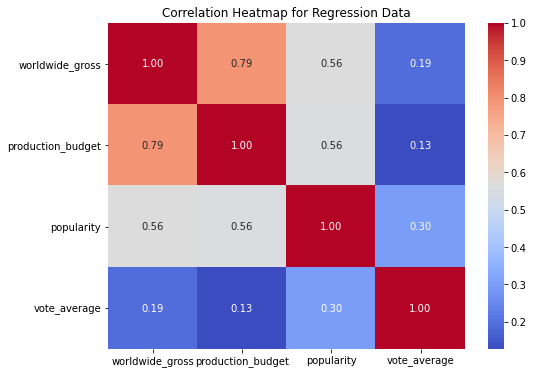

In [41]:
# Generate a heatmap for the regression data
plt.figure(figsize=(8, 6))
sns.heatmap(regression_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Regression Data")
plt.show()

The heatmap visually represents the correlation matrix for key numeric variables in the `selected_merged_movies_info` DataFrame, illustrating the strength and direction of relationships between factors like **production budget, revenue, popularity and audience ratings**. It highlights which variables are strongly correlated, offering valuable insights into potential predictors of movie success. 

Positive correlations in the heatmap indicate that as one variable increases, the other tends to increase as well. For example, worldwide gross shows a strong positive correlation with production budget, suggesting that higher investments in production often lead to higher global revenue. Similarly, popularity and vote average exhibit moderate positive correlations with worldwide gross, implying that more popular movies and those with higher audience ratings tend to perform better financially. Negative correlations, on the other hand, suggest an inverse relationship, but in this context, such correlations are either weak or negligible, indicating that most variables positively contribute to movie success.

In [42]:
from statsmodels.api import OLS, add_constant
import statsmodels.api as sm


# Prepare the data for regression
X = regression_data[['production_budget', 'popularity', 'vote_average']]
y = regression_data['worldwide_gross']

# Add a constant to the independent variables to allow the model to estimate an intercept
X = add_constant(X)

# Fit the model
model = OLS(y, X).fit()

# Display the summary of the regression model
print(model.summary())

# Extract effect sizes (coefficients) and t-values
coefficients = model.params
t_values = model.tvalues

# Display the effect sizes and t-values
effect_size_tvalue = pd.DataFrame({
    'Feature': coefficients.index,
    'Effect Size (Coefficient)': coefficients.values,
    'T-Value': t_values.values
})
print(effect_size_tvalue)

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     1507.
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        22:03:55   Log-Likelihood:                -47943.
No. Observations:                2385   AIC:                         9.589e+04
Df Residuals:                    2381   BIC:                         9.592e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.032e+08   1.42e+0

The regression analysis examines the relationship between **worldwide gross revenue** and three key factors: **production budget**, **popularity**, and **average audience rating**. The model explains **65.5%** of revenue variance, with all predictors showing statistical significance. A **$1 increase** in production budget corresponds to an estimated **$3.02** rise in revenue, while popularity and audience ratings significantly impact earnings, reinforcing the importance of marketing and content quality. The findings suggest that **mid-sized budgets ($50M–$150M), strong promotional efforts, and high audience ratings** are crucial for maximizing a movie's financial success.


In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [44]:
# Print the R-squared score and Mean Squared Error (MSE)
print(f"R-squared Score: {r2}")
print(f"Mean Squared Error (MSE): {mse}")

R-squared Score: 0.6169606832648233
Mean Squared Error (MSE): 1.5917210753080634e+16


The R-squared (R²) value of **0.6169** indicates that approximately **61.69%** of the variance in worldwide gross revenue can be explained by the independent variables: production budget, popularity, and vote average. This suggests a moderately strong relationship between these predictors and the target variable. 

The Mean Squared Error (MSE) of **1.59e+16** represents the average squared difference between the predicted and actual worldwide gross values. While the MSE provides a measure of prediction error, its large magnitude reflects the scale of the revenue data, which is in billions, making it less interpretable without normalization or comparison to other models.

### Conclusions 

- Focus on high performing genres which include adventure, action and mystery which had the 3 highest average domestic gross. 

- Average gross revenue by season shows that Summer has the highest average worldwide and domestic gross, followed by Spring. Winter and Fall have comparatively lower average gross revenues.

- The movies with rating more than 8 had the most average domestic gross. 

- Most of the genres are averagely rated other than Horror and TV movies. 

- Production budgets between $50m and $150m has a higher worlwide gross.

### Recommendations

- Launch with Mid-Budget Blockbusters which are action and adventure between May and July.

- Launch movies around summer season for more gross revenues. 

- Focus on genres of movies with higher average ratings so as to have more domestic gross.

- When making movies, focus on the genres of movies with higher ratings for more domestic gross. Averagely rated movies make the most money domestically.

- Focus on other genres of movies that are averagely rated. 

- Focus on mid sized production budgets between $50m and $150m to optimize return on investment and avoid high risk. 

### The Next Steps

1. Refine Genre and Seasonal Strategy: perform deeper analyses on sub-genres within Adventure, Action, and Mystery to identify niche markets or investigate specific summer months (e.g., June vs. July) to pinpoint the most profitable movie release windows.
2. Assess Budget Allocation: conduct sensitivity analyses to further validate the recommended budget range of $50M–$150M and explore cost-reduction opportunities in production workflows while maintaining quality.
3. Test the Recommendations: utilize A/B testing on smaller-scale movie launches to validate insights (e.g., releasing movies with different budgets or genres in summer vs. winter) and compare gross revenue outcomes to ensure alignment with expected patterns.
